In [3]:
import torch
from torch import nn

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(nn.Linear(2, 128),
                                 nn.SiLU(),
                                 nn.Linear(128, 128),
                                 nn.SiLU(),
                                 nn.Linear(128, 128),
                                 nn.SiLU(),
                                 nn.Linear(128, 1),
                                 )
        
    def forward(self, input):
        assert input.shape[-1] == 2, "Input's last dimension must be 2"
        return self.net(input)

In [199]:
a = torch.Tensor([3., 2]).unsqueeze(0)
print(a, a.shape)
model = Model()
out = model(a)
print(out, out.shape)

tensor([[3., 2.]]) torch.Size([1, 2])
tensor([[0.0543]], grad_fn=<AddmmBackward0>) torch.Size([1, 1])


In [200]:
from torch.utils.data import DataLoader, Dataset

In [214]:
class myDataset(Dataset):
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.cat([self.x[idx], self.y[idx]], dim=0), self.z[idx]

In [215]:
def original_function(x, y):
    # return torch.sin(x) * torch.sin(y)
    return  torch.exp(-((x - 0.5)**2 + (y - 0.5)**2)/0.1)

In [227]:
x = torch.rand(10000).unsqueeze(1)
t = torch.rand(10000).unsqueeze(1)
z = original_function(x, t)

dataset = myDataset(x, t, z)
print(dataset[0], dataset[0][0].shape)
chunksize = 100
dataloader = DataLoader(dataset, batch_size=chunksize, shuffle=True)

(tensor([0.3442, 0.5198]), tensor([0.7815])) torch.Size([2])


In [228]:
from torch.optim import Adam, SGD
from torch.nn import MSELoss
from tqdm import tqdm

model = Model()
epochs = 40

model.train()
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = MSELoss()

for epoch in ( bar := tqdm(range(epochs))):
    running_loss = 0.0

    for i, (x, z) in enumerate(dataloader):
        out = model(x) 
        assert out.shape == z.shape, f"Output shape {out.shape} does not match target shape {z.shape}"
        loss = criterion(out, z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    bar.set_postfix_str(f"Epoch: {epoch + 1}, Batch Loss: {running_loss}")

100%|██████████| 40/40 [00:08<00:00,  4.55it/s, Epoch: 40, Batch Loss: 0.003997863410404534] 


In [232]:
x = torch.linspace(0, 1, 100).unsqueeze(1)
t = torch.linspace(0, 1, 100).unsqueeze(1)
X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
print(X.shape)

torch.Size([100, 100])


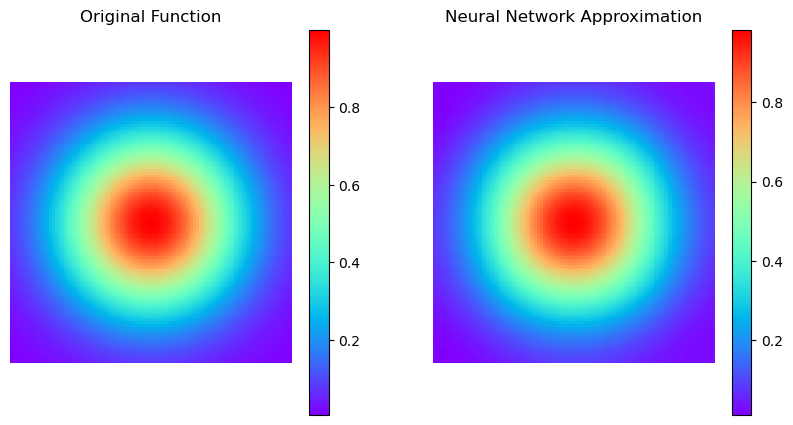

In [233]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(original_function(X, T).view(100, 100).detach().numpy(), cmap='rainbow')
    plt.axis('off')
    plt.axis('equal')
    plt.title('Original Function')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    X = X.view(100, 100, 1)
    T = T.view(100, 100, 1)
    out = model(torch.cat([X, T], dim=2))
    plt.pcolormesh(out.view(100, 100).detach().numpy(), cmap='rainbow')
    plt.axis('off')
    plt.axis('equal')
    plt.title('Neural Network Approximation')
    plt.colorbar()

In [237]:
x0 = torch.rand((1,1))
t0 = torch.rand((1,1))
model.eval()
with torch.no_grad():
    print(original_function(x0, t0), model(torch.cat([x0, t0], dim=1)))  # Should be close after training

tensor([[0.1091]]) tensor([[0.1102]])


In [12]:
import torch
torch.floor(torch.rand(10, 1)*2)*2-1

tensor([[-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.]])